In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import torch
import json
import os
import sys

from torch_geometric.data   import Batch
from torch_geometric.loader import DataLoader
from libraries.model        import nGCNN, eGCNN, diffusion_step, get_graph_losses, add_features_to_graph, predict_noise, diffuse, denoise, EarlyStopping, get_alpha_t
from libraries.dataset      import standardize_dataset, get_datasets

# Set colormap
cmap = plt.get_cmap('plasma')

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/claudio/cibran/Work/UPC/GenerativeModels/venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device

device(type='cuda')

In [3]:
# Based on adding and removing noise to graphs, he model is able to learn hidden patterns
# It can be conditionally trained with respect to some target property
# Although denoising includes noise, I think it is better not to add it when training

In [4]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'Loaded_MP_bandgap-sphere-images'  # 'MChX', 'GM_PT_EPA-sphere-images'

# Define folder in which data is stored
data_folder = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

target_folder = None
if target_folder is None:
    # Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
    i = 0
    while True:
        target_folder = f'{general_folder}/GM_v{i}'
        if not os.path.exists(target_folder):
            # Copy all data
            os.system(f'cp -r {data_folder} {target_folder}')
            break
        i += 1

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'
target_folder

'models/Loaded_MP_bandgap-sphere-images/GM_v0'

In [5]:
# Machine-learning parameters
n_epochs      = 100
batch_size    = 256
learning_rate = 0.0001
patience      = n_epochs
delta         = 0.2
check_labels  = False  # Whether to train-test split attending to labels or not

# Number of diffusing and denoising steps
n_t_steps = torch.tensor(1000, dtype=torch.int, device=device)

# Amount of noise for the generative process
sigma = torch.tensor(0, dtype=torch.int, device=device)  # Zero for training purposes

# Decay of parameter alpha
noise_contribution = torch.tensor(0.99998, dtype=torch.int, device=device)
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.1
dropout_edge = 0.1

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'patience':           patience,
    'delta':              delta,
    'check_labels':       check_labels,
    'n_t_steps':          n_t_steps.cpu().numpy().tolist(),
    'sigma':              sigma.cpu().numpy().tolist(),
    'noise_contribution': noise_contribution.cpu().numpy().tolist(),
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [6]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
labels_name_std             = f'{target_folder}/standardized_labels.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name_std):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std, weights_only=False)
    labels  = torch.load(labels_name_std,  weights_only=False)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name, weights_only=False)
    labels  = torch.load(labels_name,  weights_only=False)
    
    # Standardize dataset
    dataset, labels, dataset_parameters = standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in dataset_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Include features and prepare shape of dataset for training, considerably reducing CPU-GPU communication.

In [7]:
# Determine number of graphs in dataset
n_graphs = len(dataset)

# Determine number of node-level features in dataset
n_node_features = dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(dataset[0].y)

# Make room for n_graph_features and t_steps in the dataset
for idx in range(n_graphs):
    dataset[idx] = add_features_to_graph(dataset[idx],
                                         torch.tensor([dataset[idx].y, 0]))

Split in train, validation and test sets

In [8]:
train_ratio = 0.98
test_ratio  = 0.01

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = labels.copy()

if check_labels:
    if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
        # Read labels splitting (which are strings)
        train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
        val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
        test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
    else:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
        
        # Shuffle the list of unique labels
        np.random.shuffle(unique_labels)
    
        # Define the sizes of the train and test sets
        # Corresponds to the size wrt the number of unique materials in the dataset
        train_size = int(train_ratio * len(unique_labels))
        test_size  = int(test_ratio  * len(unique_labels))
        
        train_labels = unique_labels[:train_size]
        val_labels   = unique_labels[train_size:-test_size]
        test_labels  = unique_labels[-test_size:]
    
        # Save this splitting for transfer-learning approaches
        np.savetxt(path_to_train_labels, train_labels, fmt='%s')
        np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
        np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

    # Use the computed indexes to generate train and test sets
    # We iteratively check where labels equals a unique train/test labels and append the index to a list
    train_dataset = get_datasets(train_labels, material_labels, dataset)
    val_dataset   = get_datasets(val_labels,   material_labels, dataset)
    test_dataset  = get_datasets(test_labels,  material_labels, dataset)
else:
    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(dataset))
    test_size  = int(test_ratio  * len(dataset))

    np.random.shuffle(dataset)
    # Random, fast splitting
    train_dataset = dataset[:train_size]
    val_dataset   = dataset[train_size:-test_size]
    test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 130579
Number of validation graphs: 1333
Number of testing    graphs: 1332


Define data loaders.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Definition of the model

In [10]:
# Instantiate the models for nodes and edges, considering the t_step information; n_graph_features+1 for accounting for the time step
node_model = nGCNN(n_node_features, n_graph_features+1, dropout_node).to(device)
edge_model = eGCNN(n_node_features, n_graph_features+1, dropout_edge).to(device)

# Load previous model if available
try:
    # Load and evaluate model state
    node_model.load_state_dict(torch.load(node_model_name, map_location=torch.device(device), weights_only=False))
    node_model.eval()
    edge_model.load_state_dict(torch.load(edge_model_name, map_location=torch.device(device), weights_only=False))
    edge_model.eval()
except FileNotFoundError:
    pass

# Allow data parallelization among multi-GPU
node_model= nn.DataParallel(node_model)
edge_model= nn.DataParallel(edge_model)

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
DataParallel(
  (module): nGCNN(
    (conv1): GraphConv(6, 256)
    (conv2): GraphConv(256, 512)
    (conv3): GraphConv(512, 256)
    (conv4): GraphConv(256, 4)
    (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

Edge GCNN:
DataParallel(
  (module): eGCNN(
    (linear1): Linear(in_features=7, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=64, bias=True)
    (linear4): Linear(in_features=64, out_features=1, bias=True)
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


# Training of the model

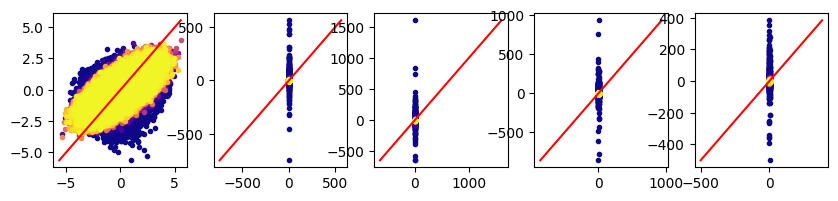

Epoch: 1, edge loss: 0.5034, node loss: 0.8540 0.8566 0.8869 0.8214


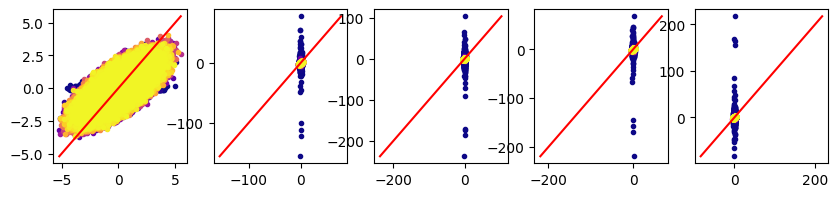

Epoch: 2, edge loss: 0.5031, node loss: 0.5249 0.5305 0.5251 0.5257


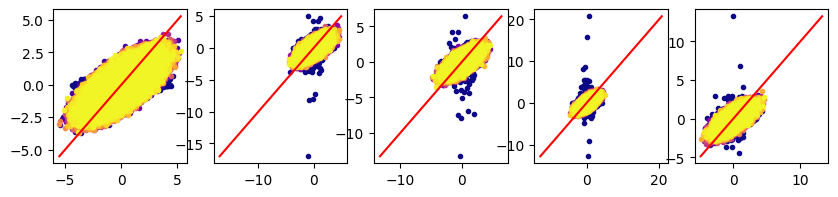

Epoch: 3, edge loss: 0.5031, node loss: 0.5045 0.5045 0.5056 0.5053


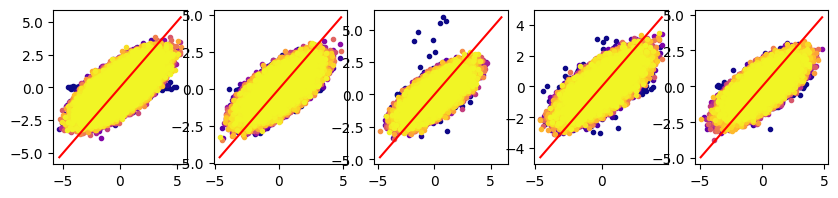

Epoch: 4, edge loss: 0.5031, node loss: 0.5035 0.5037 0.5048 0.5047


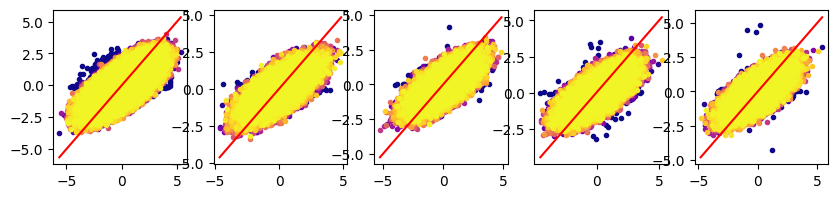

Epoch: 5, edge loss: 0.5031, node loss: 0.5035 0.5034 0.5043 0.5044


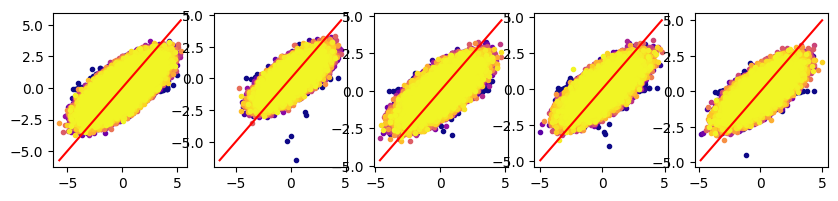

Epoch: 6, edge loss: 0.5031, node loss: 0.5035 0.5033 0.5041 0.5041


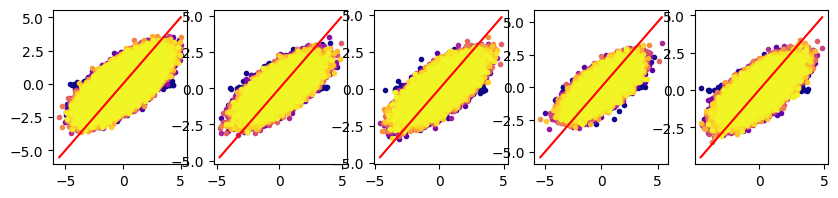

Epoch: 7, edge loss: 0.5030, node loss: 0.5030 0.5031 0.5040 0.5040


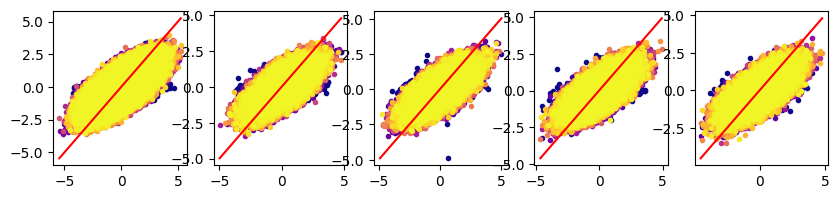

Epoch: 8, edge loss: 0.5030, node loss: 0.5028 0.5030 0.5039 0.5039


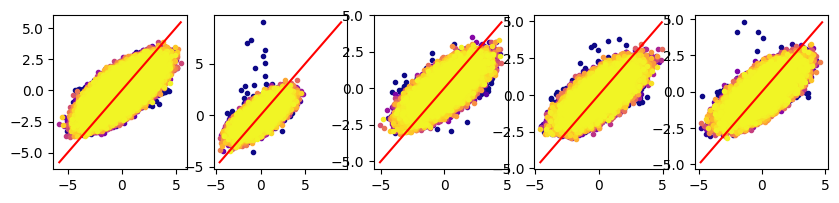

Epoch: 9, edge loss: 0.5030, node loss: 0.5027 0.5029 0.5038 0.5038


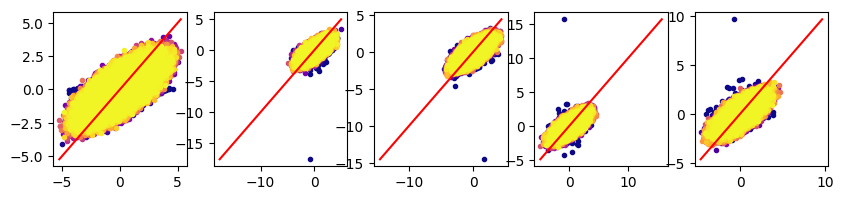

Epoch: 10, edge loss: 0.5030, node loss: 0.5026 0.5028 0.5037 0.5037


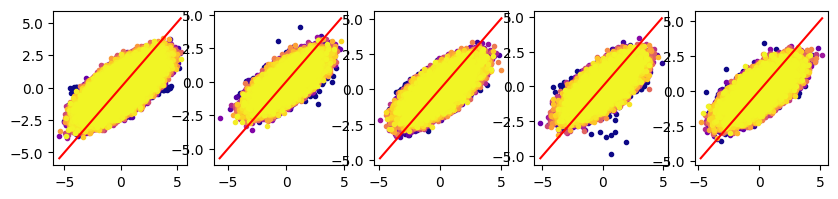

Epoch: 11, edge loss: 0.5030, node loss: 0.5026 0.5027 0.5036 0.5036


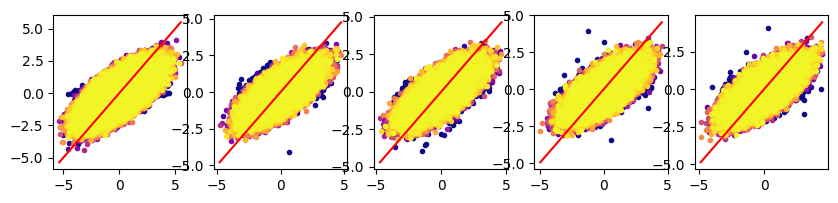

Epoch: 12, edge loss: 0.5030, node loss: 0.5025 0.5026 0.5036 0.5036


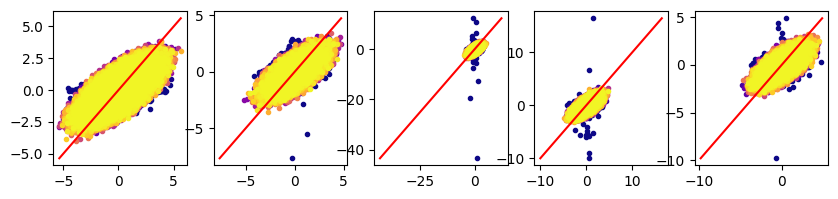

Epoch: 13, edge loss: 0.5030, node loss: 0.5025 0.5025 0.5035 0.5034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77ca711d1580>
Traceback (most recent call last):
  File "/home/claudio/cibran/Work/UPC/GenerativeModels/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/claudio/cibran/Work/UPC/GenerativeModels/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/select

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x77ca71f21f80> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x77c95d047ba0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [11]:
node_attributes_list = ['edge_attr', 'atomic_mass', 'charge', 'electronegativity', 'ionization_energy']

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Initialize early stopping
node_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=node_model_name)
edge_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=edge_model_name)

# Training loop
edge_train_losses = []
node_train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    edge_loss_cum = 0
    node_loss_cum = np.zeros(n_node_features, dtype=float)
    ground_truth = {k: [] for k in node_attributes_list}
    prediction   = {k: [] for k in node_attributes_list}
    
    fig, ax = plt.subplots(1, len(node_attributes_list), figsize=(10, 2))

    for batch_idx, batch_0 in enumerate(train_loader):
        # Clone batch of graphs and move to device
        g_batch_0 = batch_0.clone().to(device)

        # Start denoising-diffusing process
        for t_step in torch.arange(n_t_steps, device=device):
            # Initialize the gradient of the optimizers
            node_optimizer.zero_grad()
            edge_optimizer.zero_grad()
            
            # Standard normalization for the time step, which is added to node-level graph embeddings after 
            t_step_std = t_step / n_t_steps - 0.5 
            
            # Get amount of noise that is added
            alpha_t = get_alpha_t(t_step, n_t_steps, alpha_decay)
            
            # Diffuse the entire batch of graphs with Gaussian noise
            # Vectorized version of diffusion_step for batching
            g_batch_t, e_batch_t = diffusion_step(g_batch_0, alpha_t, n_features=n_node_features)
            
            # Stack time step across batch dimension 
            g_batch_t.x[:, -1] = t_step_std

            # Update diffused batch as next one
            g_batch_0 = g_batch_t.clone()
            
            # Predict batch noise at given time step
            pred_epsilon_t = predict_noise(g_batch_t, node_model, edge_model)

            # Calculate the losses for node features and edge attributes
            node_losses, edge_loss = get_graph_losses(e_batch_t, pred_epsilon_t)
            
            # Combine losses for each attribute tensors
            node_loss = torch.stack(node_losses).sum()
            
            # Get items
            node_loss_cum += np.array([node_loss.item() for node_loss in node_losses])
            edge_loss_cum += edge_loss.item()
            
            # Backpropagate and optimize node loss
            if not node_early_stopping.early_stop:
                node_loss.backward(retain_graph=True)
                #torch.nn.utils.clip_grad_norm_(node_model.parameters(), max_norm=2.0)
                node_optimizer.step()

            # Backpropagate and optimize edge loss
            if not edge_early_stopping.early_stop:
                edge_loss.backward(retain_graph=True)
                #torch.nn.utils.clip_grad_norm_(edge_model.parameters(), max_norm=2.0)
                edge_optimizer.step()

            # Randomly sample batches to store data
            if not t_step%10 and batch_idx == 0:
                for key, idx in zip(node_attributes_list, range(n_node_features+1)):
                    # In this order: edge_attr, x0, x1, x2, x3, ... to lists
                    gt_value   = (     e_batch_t.edge_attr if not idx else      e_batch_t.x[:, idx-1]).cpu().detach().numpy().tolist()
                    pred_value = (pred_epsilon_t.edge_attr if not idx else pred_epsilon_t.x[:, idx-1]).cpu().detach().numpy().tolist()

                    # Append to dictionaries
                    ground_truth[key].append(gt_value)
                    prediction[key].append(pred_value)

                    ax[idx].plot(gt_value, pred_value, '.', color=cmap(((t_step + 1) / n_t_steps).cpu().detach().numpy()))
    
    # Plot once per epoch
    for idx, item in enumerate(ground_truth):
        gt_values   = np.concatenate(ground_truth[item])
        pred_values = np.concatenate(prediction[item])
        
        _min, _max = min(gt_values.min(), pred_values.min()), max(gt_values.max(), pred_values.max())
        ax[idx].plot([_min, _max], [_min, _max], '-r')
    plt.show()

    # Compute the average train loss over n_t_steps
    node_loss_cum /= (n_t_steps.cpu().numpy() * len(train_loader))
    edge_loss_cum /= (n_t_steps.cpu().numpy() * len(train_loader))

    # Append average losses
    node_train_losses.append(node_loss_cum)
    edge_train_losses.append(edge_loss_cum)

    # Check early stopping criteria
    node_early_stopping(node_loss_cum.sum(), node_model)
    edge_early_stopping(edge_loss_cum,       edge_model)

    if node_early_stopping.early_stop and edge_early_stopping.early_stop:
        print('Early stopping')
        break

    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Epoch: {epoch+1}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [ ]:
rescaled_edge_train_losses = np.sqrt(edge_train_losses) * dataset_parameters['edge_std'].numpy() + dataset_parameters['edge_mean'].numpy()
rescaled_edge_train_losses

In [ ]:
node_train_losses = np.array(node_train_losses)
rescaled_node_loss_cum = np.sqrt(node_train_losses) * dataset_parameters['feat_std'].numpy() + dataset_parameters['feat_mean'].numpy()
rescaled_node_loss_cum

In [ ]:
plt.plot(np.log(edge_train_losses), label='Edge')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(np.log(np.array(node_train_losses)[:, 0]), label=f'Atomic mass')
plt.plot(np.log(np.array(node_train_losses)[:, 1]), label=f'Charge')
plt.plot(np.log(np.array(node_train_losses)[:, 2]), label=f'Electronegativity')
plt.plot(np.log(np.array(node_train_losses)[:, 3]), label=f'Ionization energy')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.savefig('Losses.eps', dpi=50, bbox_inches='tight')
plt.show()

# Test of the model

In [ ]:
def denoising_step(batch_t, epsilon, alpha_t, sigma, n_features=None):
    """Performs a forward step of a denoising chain.

    Args:
        batch_t    (Batch): Batch of graphs to be diffused.
        epsilon    (Batch): Predicted noise to subtract.
        alpha_t    (float): Constant from the step of the diffusion process.
        sigma      (float): Parameter which controls the amount of noised added when generating.
        n_features (int):   Number of node features to be diffused (:n_features).

    Returns:
        graph_0 (torch_geometric.data.Data): Denoised graph (step t-1).
    """

    # Clone the original batch of graphs to prevent in-place modifications
    batch_0 = batch_t.clone()

    # Number of nodes and features per graph
    n_nodes    = batch_t.x.size(0)
    n_features = n_features if n_features is not None else batch_t.x.size(1)
    
    # Generate gaussian (normal) noise
    epsilon_t = get_random_graph(n_nodes, n_features, batch_0.edge_index)
    
    # Backward pass
    #print('eps', batch_0.x)
    #print('err', epsilon.x)
    batch_0.x[:, :n_features] = batch_0.x[:, :n_features] / torch.sqrt(alpha_t) - torch.sqrt((1 - alpha_t) / alpha_t) * epsilon.x         + sigma * epsilon_t.x
    batch_0.edge_attr         = batch_0.edge_attr         / torch.sqrt(alpha_t) - torch.sqrt((1 - alpha_t) / alpha_t) * epsilon.edge_attr + sigma * epsilon_t.edge_attr
    
    #print('ss', batch_0.x)
    return batch_0



def denoise(batch_t, n_t_steps, node_model, edge_model, alpha_decay=1e-2, sigma=None, plot_steps=False, n_features=None):
    """Performs consecutive steps of diffusion in a reference batch of graphs.

    Args:
        batch_t     (Batch):           Reference batch of graphs to be denoised (step t-1).
        n_t_steps   (int):             Number of diffusive steps.
        node_model  (torch.nn.Module): Model for graph-node prediction.
        edge_model  (torch.nn.Module): Model for graph-edge prediction.
        alpha_decay (float):           Parameter which controls the decay of alpha with t.
        sigma       (float):           Parameter which controls the amount of noised added when generating.
        plot_steps  (bool, int):       Whether to plot each intermediate step, or which graph from batch.
        n_features  (int):             Number of node features to be diffused (:n_features).

    Returns:
        graph_0 (torch_geometric.data.Data): Graph with random node features and edge attributes (step t).
    """

    # Clone batch of graphs and move to device
    batch_0 = batch_t.clone().to(device)

    for t_step in torch.arange(n_t_steps, device=device):
        # Standard normalization for the time step, which is added to node-level graph embeddings after
        t_step_std = t_step / n_t_steps - 0.5

        # Stack time step across batch dimension
        batch_0.x[:, -1] = t_step_std

        # Predict batch noise at given time step
        pred_epsilon_t = predict_noise(batch_0, node_model, edge_model)

        print(torch.any(torch.isnan(batch_0.x)), torch.any(torch.isnan(batch_0.edge_attr)))
        print(torch.any(torch.isnan(pred_epsilon_t.x)), torch.any(torch.isnan(pred_epsilon_t.edge_attr)))

        # Check if intermediate steps are plotted; then, plot the NetworkX graph
        if plot_steps:
            # Convert PyTorch graph to NetworkX graph
            networkx_graph = to_networkx(batch_0[plot_steps])
            pos            = nx.spring_layout(networkx_graph)
            nx.draw(networkx_graph, pos, with_labels=True, node_size=batch_0[plot_steps].x, font_size=10)
            plt.show()

        # Compute alpha_t and denoise batch altogether
        alpha_t = get_alpha_t(t_step, n_t_steps, alpha_decay)
        print('alpha', t_step, alpha_t)
        
        batch_0 = denoising_step(batch_0, pred_epsilon_t, alpha_t, sigma, n_features=n_features)
        
    # Check if intermediate steps are plotted; then, plot the NetworkX graph
    if plot_steps:
        # Convert PyTorch graph to NetworkX graph
        networkx_graph = to_networkx(batch_0[plot_steps])
        pos            = nx.spring_layout(networkx_graph)
        nx.draw(networkx_graph, pos, with_labels=True, node_size=batch_0[plot_steps].x, font_size=10)
        plt.show()
    return batch_0

In [ ]:
# Training loop
edge_test_losses = 0
node_test_losses = np.zeros(n_node_features, dtype=float)
with torch.no_grad():
    for batch_idx, batch_0 in enumerate(test_loader):
        # Move batch to device
        batch_0 = batch_0.to(device)
        
        # Clone batch of graphs and move to device
        g_batch_0 = batch_0.clone()
        
        # Diffuse batch
        g_batch_t = diffuse(g_batch_0, n_t_steps, alpha_decay)
        
        # Denoise batch
        g_batch_0 = denoise(g_batch_t, n_t_steps, node_model, edge_model, alpha_decay=alpha_decay,
                            sigma=model_parameters['sigma'], n_features=n_node_features)
        
        # Calculate the loss for node features and edge attributes
        node_losses, edge_loss = get_graph_losses(batch_0, g_batch_0)
        
        # Get items
        node_loss_cum = np.array([node_loss.item() for node_loss in node_losses])[:n_node_features]
        edge_loss_cum = edge_loss.item()
        
        # Append average losses
        edge_test_losses += edge_loss_cum
        node_test_losses += node_loss_cum
        
        print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
        print(f'Batch: {batch_idx}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [ ]:
# Mean loss per noise step on edges and nodes
edge_test_losses /= len(test_loader)
node_test_losses /= len(test_loader)
edge_test_losses, node_test_losses

# Save results

In [ ]:
# Create and save as a dictionary
model_performance = {
    'edge_train_losses': edge_train_losses,
    'node_train_losses': np.array(node_train_losses).tolist(),
    'edge_test_losses':  edge_test_losses,
    'node_test_losses':  node_test_losses.tolist()
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_performance.json', 'w') as json_file:
    json.dump(model_performance, json_file)